In [70]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/mnt/vol_b/code/sketchpad")
from data_loader import KeypointsDataset, tfs
from pathlib import Path
import timm
import torch
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


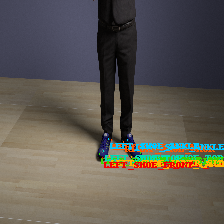

In [72]:
ds = KeypointsDataset(data_path=Path("/mnt/vol_b/clean_data/tmp2"), transform=tfs)
sample, _ = ds.plot_sample(1)
sample

In [9]:

# model = timm.create_model("hrnet_w18", pretrained=True, num_classes=2*12)
# tensor, _ = ds[0]
# with torch.no_grad():
#     preds = model(tensor.unsqueeze(0))
    
# model

In [75]:

model = timm.create_model('hrnet_w18', pretrained=True,features_only=True, num_classes=0, global_pool='')
import torch.nn.functional as F
final_inp_channels = 960
BN_MOMENTUM = 0.01
FINAL_CONV_KERNEL=1
num_points=12
head = nn.Sequential(
            nn.Conv2d(
                in_channels=final_inp_channels,
                out_channels=final_inp_channels,
                kernel_size=1,
                # stride=1,
                dilation=2,
                padding=1 ),
            nn.BatchNorm2d(final_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=final_inp_channels,
                out_channels=num_points,
                kernel_size=FINAL_CONV_KERNEL,
                dilation=2,
                stride=1,
                padding=1),
                nn.Upsample(size=(224, 224), mode="bilinear", align_corners=False),
                nn.Conv2d(in_channels=num_points, out_channels=1, kernel_size=1)

        )
tensor, (target, _, _, _) = ds[0]
with torch.no_grad():
    x = model(tensor.unsqueeze(0))

    height, width = x[0].size(2), x[0].size(3)
    x1 = F.interpolate(x[1], size=(height, width), mode='bilinear', align_corners=False)
    x2 = F.interpolate(x[2], size=(height, width), mode='bilinear', align_corners=False)
    x3 = F.interpolate(x[3], size=(height, width), mode='bilinear', align_corners=False)
    x = torch.cat([x[0], x1, x2, x3], 1)
    
    preds = head(x).squeeze(-1).squeeze(-1).squeeze(1)
print (preds.shape)
x.shape
# torch.Size([12, 224, 224])

torch.Size([1, 224, 224])


torch.Size([1, 960, 112, 112])

In [79]:
# filters = torch.randn(8, 4, 3, 3)
# inputs = torch.randn(1, 4, 5, 5)
# F.conv2d(inputs, filters, padding=1).shape
# torch.rand_like(target)
# F.mse_loss(target, torch.ones_like(target))
torch.empty(1, 3, 5, dtype=torch.long).random_(5).dtype

torch.int64

In [73]:
# help(nn.BatchNorm2d)
m = nn.MaxPool2d(11, stride=2)
# pool of non-square window
# m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(1, 24, 11, 11)
output = m(input)
output.shape

torch.Size([1, 24, 1, 1])

In [17]:
from kornia.feature import SIFTDescriptor, HardNet
# sd=SIFTDescriptor(32,8,4)
sd = HardNet(True)
image, _ =ds[0]
image = cv.cvtColor(image.permute(1, 2, 0).numpy().astype(np.uint8), cv.COLOR_BGR2GRAY)
sd(image)


TypeError: std_mean() received an invalid combination of arguments - got (numpy.ndarray, keepdim=bool, dim=tuple), but expected one of:
 * (Tensor input, tuple of ints dim, bool unbiased, bool keepdim)
 * (Tensor input, tuple of ints dim, *, int correction, bool keepdim)
 * (Tensor input, bool unbiased)
 * (Tensor input, tuple of names dim, bool unbiased, bool keepdim)
 * (Tensor input, tuple of names dim, *, int correction, bool keepdim)


In [13]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1, _ =ds[0]
img2, _ =ds[1]
img1 = cv.cvtColor(img1.permute(1, 2, 0).numpy().astype(np.uint8), cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2.permute(1, 2, 0).numpy().astype(np.uint8), cv.COLOR_BGR2GRAY)
img1.dtype

dtype('uint8')

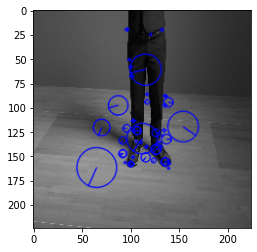

(<matplotlib.image.AxesImage at 0x7f0e91bd8cd0>, None)

In [26]:

# img1 = cv.imread('box.png',cv.IMREAD_GRAYSCALE)          # queryImage
# img2 = cv.imread('box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.95*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img1 = cv.drawKeypoints(img1,kp1, img1,color=(0,0,255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1),plt.show()


# Illustration of transforms

This example illustrates the various transforms available in `the
torchvision.transforms module <transforms>`.


In [3]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'
orig_img = Image.open(Path('assets') / 'astronaut.jpg')
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/vol_b/code/sketchpad/notebooks/assets/astronaut.jpg'

## Pad
The :class:`~torchvision.transforms.Pad` transform
(see also :func:`~torchvision.transforms.functional.pad`)
fills image borders with some pixel values.



In [ ]:
padded_imgs = [T.Pad(padding=padding)(orig_img) for padding in (3, 10, 30, 50)]
plot(padded_imgs)

## Resize
The :class:`~torchvision.transforms.Resize` transform
(see also :func:`~torchvision.transforms.functional.resize`)
resizes an image.



In [ ]:
resized_imgs = [T.Resize(size=size)(orig_img) for size in (30, 50, 100, orig_img.size)]
plot(resized_imgs)

## CenterCrop
The :class:`~torchvision.transforms.CenterCrop` transform
(see also :func:`~torchvision.transforms.functional.center_crop`)
crops the given image at the center.



In [ ]:
center_crops = [T.CenterCrop(size=size)(orig_img) for size in (30, 50, 100, orig_img.size)]
plot(center_crops)

## FiveCrop
The :class:`~torchvision.transforms.FiveCrop` transform
(see also :func:`~torchvision.transforms.functional.five_crop`)
crops the given image into four corners and the central crop.



In [ ]:
(top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(100, 100))(orig_img)
plot([top_left, top_right, bottom_left, bottom_right, center])

## Grayscale
The :class:`~torchvision.transforms.Grayscale` transform
(see also :func:`~torchvision.transforms.functional.to_grayscale`)
converts an image to grayscale



In [ ]:
gray_img = T.Grayscale()(orig_img)
plot([gray_img], cmap='gray')

## Random transforms
The following transforms are random, which means that the same transfomer
instance will produce different result each time it transforms a given image.

### ColorJitter
The :class:`~torchvision.transforms.ColorJitter` transform
randomly changes the brightness, saturation, and other properties of an image.



In [ ]:
jitter = T.ColorJitter(brightness=.5, hue=.3)
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot(jitted_imgs)

### GaussianBlur
The :class:`~torchvision.transforms.GaussianBlur` transform
(see also :func:`~torchvision.transforms.functional.gaussian_blur`)
performs gaussian blur transform on an image.



In [ ]:
blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
blurred_imgs = [blurrer(orig_img) for _ in range(4)]
plot(blurred_imgs)

### RandomPerspective
The :class:`~torchvision.transforms.RandomPerspective` transform
(see also :func:`~torchvision.transforms.functional.perspective`)
performs random perspective transform on an image.



In [ ]:
perspective_transformer = T.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot(perspective_imgs)

### RandomRotation
The :class:`~torchvision.transforms.RandomRotation` transform
(see also :func:`~torchvision.transforms.functional.rotate`)
rotates an image with random angle.



In [ ]:
rotater = T.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(orig_img) for _ in range(4)]
plot(rotated_imgs)

### RandomAffine
The :class:`~torchvision.transforms.RandomAffine` transform
(see also :func:`~torchvision.transforms.functional.affine`)
performs random affine transform on an image.



In [ ]:
affine_transfomer = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transfomer(orig_img) for _ in range(4)]
plot(affine_imgs)

### RandomCrop
The :class:`~torchvision.transforms.RandomCrop` transform
(see also :func:`~torchvision.transforms.functional.crop`)
crops an image at a random location.



In [ ]:
cropper = T.RandomCrop(size=(128, 128))
crops = [cropper(orig_img) for _ in range(4)]
plot(crops)

### RandomResizedCrop
The :class:`~torchvision.transforms.RandomResizedCrop` transform
(see also :func:`~torchvision.transforms.functional.resized_crop`)
crops an image at a random location, and then resizes the crop to a given
size.



In [ ]:
resize_cropper = T.RandomResizedCrop(size=(32, 32))
resized_crops = [resize_cropper(orig_img) for _ in range(4)]
plot(resized_crops)

### RandomInvert
The :class:`~torchvision.transforms.RandomInvert` transform
(see also :func:`~torchvision.transforms.functional.invert`)
randomly inverts the colors of the given image.



In [ ]:
inverter = T.RandomInvert()
invertered_imgs = [inverter(orig_img) for _ in range(4)]
plot(invertered_imgs)

### RandomPosterize
The :class:`~torchvision.transforms.RandomPosterize` transform
(see also :func:`~torchvision.transforms.functional.posterize`)
randomly posterizes the image by reducing the number of bits
of each color channel.



In [ ]:
posterizer = T.RandomPosterize(bits=2)
posterized_imgs = [posterizer(orig_img) for _ in range(4)]
plot(posterized_imgs)

### RandomSolarize
The :class:`~torchvision.transforms.RandomSolarize` transform
(see also :func:`~torchvision.transforms.functional.solarize`)
randomly solarizes the image by inverting all pixel values above
the threshold.



In [ ]:
solarizer = T.RandomSolarize(threshold=192.0)
solarized_imgs = [solarizer(orig_img) for _ in range(4)]
plot(solarized_imgs)

### RandomAdjustSharpness
The :class:`~torchvision.transforms.RandomAdjustSharpness` transform
(see also :func:`~torchvision.transforms.functional.adjust_sharpness`)
randomly adjusts the sharpness of the given image.



In [ ]:
sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=2)
sharpened_imgs = [sharpness_adjuster(orig_img) for _ in range(4)]
plot(sharpened_imgs)

### RandomAutocontrast
The :class:`~torchvision.transforms.RandomAutocontrast` transform
(see also :func:`~torchvision.transforms.functional.autocontrast`)
randomly applies autocontrast to the given image.



In [ ]:
autocontraster = T.RandomAutocontrast()
autocontrasted_imgs = [autocontraster(orig_img) for _ in range(4)]
plot(autocontrasted_imgs)

### RandomEqualize
The :class:`~torchvision.transforms.RandomEqualize` transform
(see also :func:`~torchvision.transforms.functional.equalize`)
randomly equalizes the histogram of the given image.



In [ ]:
equalizer = T.RandomEqualize()
equalized_imgs = [equalizer(orig_img) for _ in range(4)]
plot(equalized_imgs)

### AutoAugment
The :class:`~torchvision.transforms.AutoAugment` transform
automatically augments data based on a given auto-augmentation policy.
See :class:`~torchvision.transforms.AutoAugmentPolicy` for the available policies.



In [ ]:
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
augmenters = [T.AutoAugment(policy) for policy in policies]
imgs = [
    [augmenter(orig_img) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot(imgs, row_title=row_title)

## Randomly-applied transforms

Some transforms are randomly-applied given a probability ``p``.  That is, the
transformed image may actually be the same as the original one, even when
called with the same transformer instance!

### RandomHorizontalFlip
The :class:`~torchvision.transforms.RandomHorizontalFlip` transform
(see also :func:`~torchvision.transforms.functional.hflip`)
performs horizontal flip of an image, with a given probability.



In [ ]:
hflipper = T.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(orig_img) for _ in range(4)]
plot(transformed_imgs)

### RandomVerticalFlip
The :class:`~torchvision.transforms.RandomVerticalFlip` transform
(see also :func:`~torchvision.transforms.functional.vflip`)
performs vertical flip of an image, with a given probability.



In [ ]:
vflipper = T.RandomVerticalFlip(p=0.5)
transformed_imgs = [vflipper(orig_img) for _ in range(4)]
plot(transformed_imgs)

### RandomApply
The :class:`~torchvision.transforms.RandomApply` transform
randomly applies a list of transforms, with a given probability.



In [ ]:
applier = T.RandomApply(transforms=[T.RandomCrop(size=(64, 64))], p=0.5)
transformed_imgs = [applier(orig_img) for _ in range(4)]
plot(transformed_imgs)